In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
english_stopwords = [stemmer.stem(stopword) for stopword in stopwords.words("english")]
stemmer = PorterStemmer()

In [3]:
dataset = load_dataset("dair-ai/emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/nikit/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [100]:
train_texts_l = dataset["train"]["text"]
train_labels_l = dataset["train"]["label"]

val_texts_l = dataset["validation"]["text"]
val_labels_l = dataset["validation"]["label"]

In [26]:
LABEL_TO_EMOTION_DICT = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

In [63]:
def preprocess_word(word: str, stem=True):
    result = word
    if stem:
        result = stemmer.stem(result)
    return result

Text(0.5, 1.0, 'Class frequences in training set')

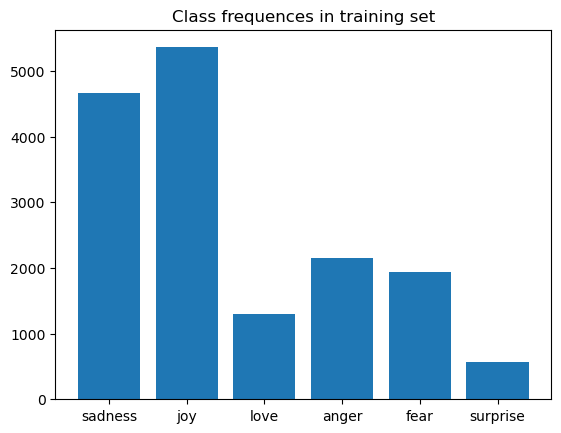

In [123]:
plt.bar(LABEL_TO_EMOTION_DICT.values(), np.unique(train_labels_l, return_counts=True)[1])
plt.title("Class frequences in training set")

## Naive Bayes

In [112]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize, preprocessor=preprocess_word, stop_words=english_stopwords)
count_vectorizer = CountVectorizer(tokenizer=word_tokenize, preprocessor=preprocess_word, stop_words=english_stopwords)

count_pipeline = Pipeline([
    ("vectorizer", count_vectorizer),
    ("classifier", MultinomialNB())
])

tfidf_pipeline = Pipeline([
    ("vectorizer", tfidf_vectorizer),
    ("classifier", MultinomialNB())
])

In [78]:
tfidf_matrix = tfidf_vectorizer.fit_transform(train_texts_l)
count_matrix = count_vectorizer.fit_transform(train_texts_l)

c:\programs\x64\conda\envs\ml_stuff\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'d", "'ll", 'becau', 'could', 'does', 'has', 'might', 'must', "n't", 'need', 'r', 'sha', 'v', 'was', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [94]:
word_features = count_vectorizer.get_feature_names_out()
counts = count_matrix.toarray().sum(axis=0)

word_counts_df = pd.DataFrame()
word_counts_df.loc[:, "word"] = word_features
word_counts_df.loc[:, "count"] = counts
word_counts_df.sort_values("count", ascending=False)

,word,count
5204,feel,11231
5208,feeling,5083
8144,like,2899
6895,im,2430
15382,was,2210
...,...,...
9320,nearing,1
3146,craps,1
9322,nearness,1
3142,cranny,1


In [128]:
count_pipeline.fit(train_texts_l, train_labels_l)
tfidf_pipeline.fit(train_texts_l, train_labels_l)
pass

### Counts as features

In [116]:
print("Count_pipeline:")

print("Train accuracy:", count_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", count_pipeline.score(val_texts_l, val_labels_l))

Count_pipeline:
Train accuracy: 0.89075
Validation accuracy: 0.7625


In [124]:
def plot_confusion_matrix(y_true, y_pred, display_labels=None):
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_display = ConfusionMatrixDisplay(conf_matrix, display_labels=display_labels)
    conf_matrix_display.plot()

Text(0.5, 1.0, 'Training set confusion matrix')

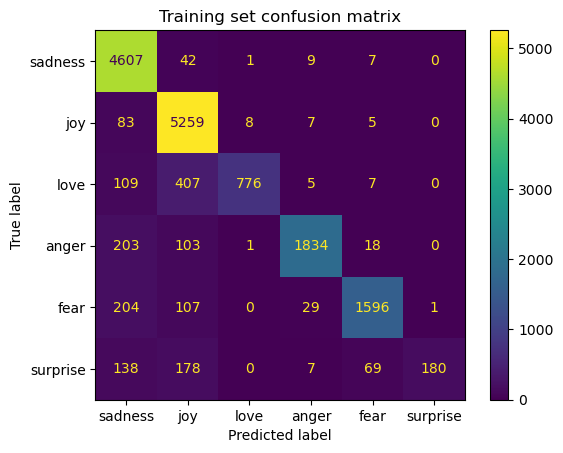

In [126]:
plot_confusion_matrix(train_labels_l, count_pipeline.predict(train_texts_l), LABEL_TO_EMOTION_DICT.values())
plt.title("Training set confusion matrix")

Text(0.5, 1.0, 'Validation set confusion matrix')

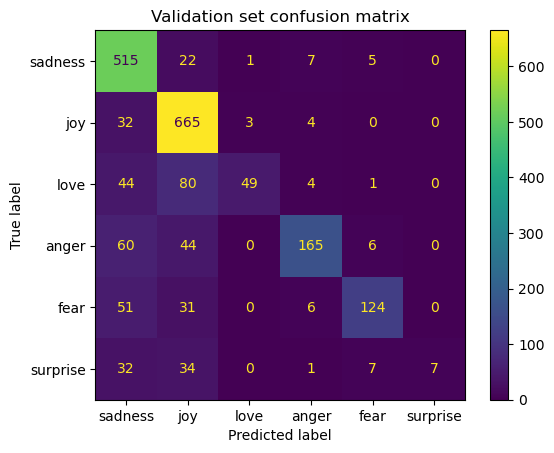

In [127]:
plot_confusion_matrix(val_labels_l, count_pipeline.predict(val_texts_l), LABEL_TO_EMOTION_DICT.values())
plt.title("Validation set confusion matrix")

### TFIDF as features

In [118]:
print("Tfidf_pipeline:")

print("Train accuracy:", tfidf_pipeline.score(train_texts_l, train_labels_l))
print("Validation accuracy:", tfidf_pipeline.score(val_texts_l, val_labels_l))

Tfidf_pipeline:
Train accuracy: 0.7273125
Validation accuracy: 0.659


Text(0.5, 1.0, 'Training set confusion matrix')

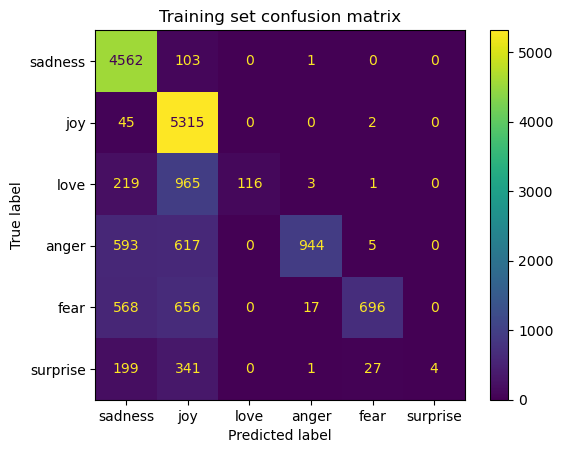

In [129]:
plot_confusion_matrix(train_labels_l, tfidf_pipeline.predict(train_texts_l), LABEL_TO_EMOTION_DICT.values())
plt.title("Training set confusion matrix")

## Logistic Regression